# Homework 4

---

## Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*




## Solution

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [85]:
def metropolis_within_gibbs_normal_gamma(
    n_iter, x, theta_0, tau_0_sq, alpha, lambda_, 
    prop_sd_theta=0.8, burn_in=1000):

    n = len(x)
    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)

    # Initialization
    theta = np.mean(x)
    tau = alpha / lambda_  # Starting at the mean of the prior for stability

    for i in range(n_iter):
        # --- Metropolis step for theta ---
        theta_proposal = np.random.normal(theta, prop_sd_theta)
        
        p_current = joint_posterior(theta, tau, x, theta_0, tau_0_sq, alpha, lambda_)
        p_proposal = joint_posterior(theta_proposal, tau, x, theta_0, tau_0_sq, alpha, lambda_)

        mh_ratio_theta = (p_proposal + 1e-12) / (p_current + 1e-12)
        if np.random.uniform() < min(1, mh_ratio_theta):
            theta = theta_proposal

        # --- Metropolis step for tau using Gamma proposal ---
        tau_proposal = np.random.gamma(shape=2, scale=tau / 2)

        p_current_tau = joint_posterior(theta, tau, x, theta_0, tau_0_sq, alpha, lambda_)
        p_proposal_tau = joint_posterior(theta, tau_proposal, x, theta_0, tau_0_sq, alpha, lambda_)

        proposal_ratio = (stats.gamma.pdf(tau, a=2, scale=tau_proposal / 2) + 1e-12) / \
                         (stats.gamma.pdf(tau_proposal, a=2, scale=tau / 2) + 1e-12)
        mh_ratio_tau = (p_proposal_tau + 1e-12) / (p_current_tau + 1e-12) * proposal_ratio

        if np.random.uniform() < min(1, mh_ratio_tau):
            tau = tau_proposal

        # Store samples
        theta_samples[i] = theta
        tau_samples[i] = tau

    # burn-in
    return theta_samples[burn_in:], tau_samples[burn_in:]


# Joint posterior
def joint_posterior(theta, tau, x, theta_0, tau_0_sq, alpha, lambda_):
    n = len(x)
    likelihood = tau ** (n / 2) * np.exp(-0.5 * tau * np.sum((x - theta) ** 2))
    prior_theta = np.exp(-0.5 * (1 / tau_0_sq) * (theta - theta_0) ** 2)
    prior_tau = tau ** (alpha - 1) * np.exp(-lambda_ * tau)
    return likelihood * prior_theta * prior_tau


# Posterior summaries
def print_posterior_summaries(theta_samples, tau_samples, label):
    print(f"{label} Posterior Summary:")
    print(f"  θ: Mean = {np.mean(theta_samples):.3f}, Std = {np.std(theta_samples):.3f}, 95% CI = {np.percentile(theta_samples, [2.5, 97.5])}")
    print(f"  τ: Mean = {np.mean(tau_samples):.3f}, Std = {np.std(tau_samples):.3f}, 95% CI = {np.percentile(tau_samples, [2.5, 97.5])}")
    print("-" * 50)


Posterior Posterior Summary:
  θ: Mean = 9.924, Std = 0.079, 95% CI = [ 9.76910192 10.0801846 ]
  τ: Mean = 3.149, Std = 0.614, 95% CI = [2.05558292 4.41400841]
--------------------------------------------------


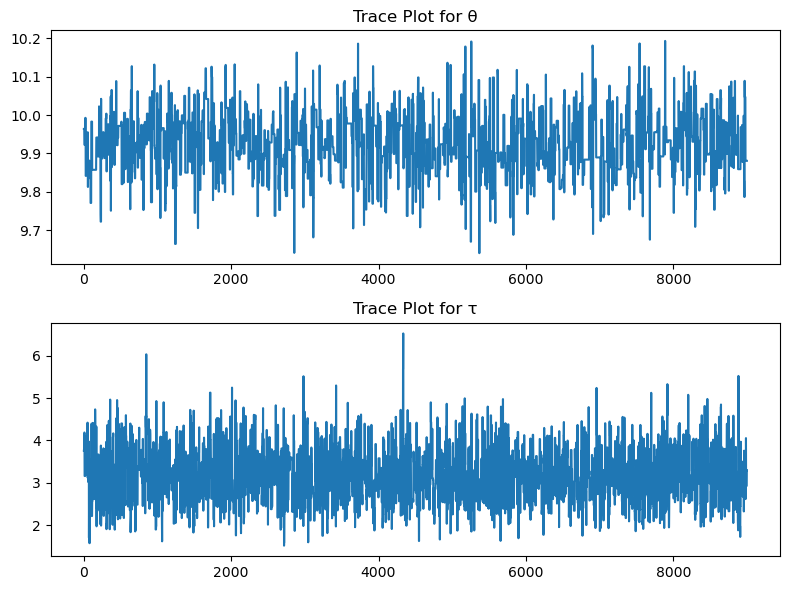

In [87]:
# Simulate
# np.random.seed(30)
n_samples = 50
true_mean = 10
true_std = 0.5

data_samples = np.random.normal(loc=true_mean, scale=true_std, size=n_samples)

# Hyperparameters
n_iter = 10000
theta_0 = 0.0
tau_0_sq = 100
alpha = 2.0
lambda_ = 1.0

# Run the sampler
theta_samples, tau_samples = metropolis_within_gibbs_normal_gamma(
    n_iter, data_samples, theta_0, tau_0_sq, alpha, lambda_
)

# Output summaries
print_posterior_summaries(theta_samples, tau_samples, "Posterior")

# Trace plots
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(theta_samples)
ax[0].set_title("Trace Plot for θ")
ax[1].plot(tau_samples)
ax[1].set_title("Trace Plot for τ")
plt.tight_layout()
plt.show()


Below is a re-run of the Normal-Gamma gibbs sampler from HW3 Q2 with aligned settings.

Posterior Summary with Weak Prior:
  θ: Mean = 9.901, Std = 0.074, 95% CI = [ 9.75467272 10.04684078]
  τ: Mean = 3.928, Std = 0.800, 95% CI = [2.52745046 5.64459519]
--------------------------------------------------


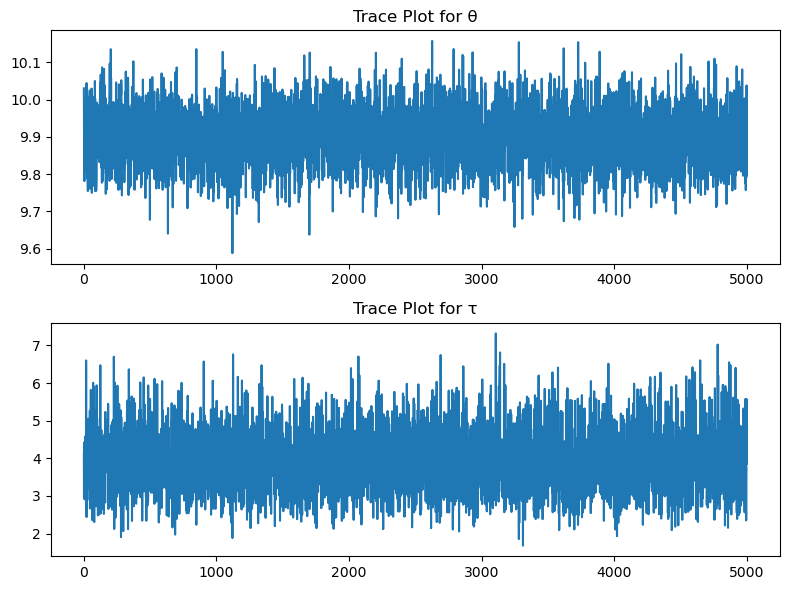

In [100]:
def gibbs_sampler_normal_gamma(n_iter, x, theta_0, tau_0_sq, alpha, lambda_):
    n = len(x)
    x_bar = np.mean(x)

    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)

    tau = np.random.gamma(alpha / 2, 2 / lambda_)

    for i in range(n_iter):
        # Sample theta from normal full conditional
        var_theta = 1 / (n * tau + 1 / tau_0_sq)
        mean_theta = var_theta * (n * tau * x_bar + theta_0 / tau_0_sq)
        theta = np.random.normal(mean_theta, np.sqrt(var_theta))

        # Sample tau from gamma full conditional
        alpha_post = alpha / 2 + n / 2
        lambda_post = lambda_ / 2 + 0.5 * np.sum((x - theta) ** 2)
        tau = np.random.gamma(alpha_post, 1 / lambda_post)

        # Store samples
        theta_samples[i] = theta
        tau_samples[i] = tau

    return theta_samples, tau_samples

# Simulated data
n_samples = 50
true_mean = 10
true_std = 0.5
data_samples = stats.norm(loc=true_mean, scale=true_std).rvs(size=n_samples)

alpha = 1
lambda_ = 1

n_iter = 5000
theta_0 = 0       # Prior mean for theta
tau_0_sq = 6      # Prior variance for theta

# Gibbs sampling
theta_samples, tau_samples = gibbs_sampler_normal_gamma(
    n_iter, data_samples, theta_0, tau_0_sq, alpha, lambda_
)

# Posterior summaries
theta_mean, theta_std = np.mean(theta_samples), np.std(theta_samples)
tau_mean, tau_std = np.mean(tau_samples), np.std(tau_samples)
theta_ci = np.percentile(theta_samples, [2.5, 97.5])
tau_ci = np.percentile(tau_samples, [2.5, 97.5])

print("Posterior Summary with Weak Prior:")
print(f"  θ: Mean = {theta_mean:.3f}, Std = {theta_std:.3f}, 95% CI = {theta_ci}")
print(f"  τ: Mean = {tau_mean:.3f}, Std = {tau_std:.3f}, 95% CI = {tau_ci}")
print("-" * 50)

# Trace plots
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(theta_samples)
ax[0].set_title("Trace Plot for θ")
ax[1].plot(tau_samples)
ax[1].set_title("Trace Plot for τ")

plt.tight_layout()
plt.show()

The Gibbs sampler produces wider credible interval for tau compared to the Metropolis-within-Gibbs sampler, though the difference for theta is negligible. Both models used weak priors, but the Gibbs sampler is more sensitive to the data due to direct sampling from full conditionals. The Metropolis-within-Gibbs, on the other hand, balances the prior and likelihood through acceptance probabilities, leading to more conservative posterior estimates.

&nbsp;

## Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof) of analytically determining the full conditional distributions when performing Gibbs sampling.*





### Solution

In [125]:
def metropolis_within_gibbs_truncnorm(n_iter, x, alpha, beta, s_theta, s_tau):

    n = len(x)
    theta_samples = np.zeros(n_iter)
    tau_samples = np.zeros(n_iter)

    theta = 2 
    tau = 1 

    accept_theta = 0
    accept_tau = 0

    for i in range(n_iter):
        # --- Metropolis-Hastings Step for tau (Truncated Normal Proposal) ---
        tau_current = tau
        a_current = -tau_current / s_tau  # Lower bound for truncation
        tau_proposal = stats.truncnorm(a=a_current, b=np.inf, loc=tau_current, scale=s_tau).rvs()

        p_current_tau = joint_posterior(theta, tau_current, x, alpha, beta)
        p_proposal_tau = joint_posterior(theta, tau_proposal, x, alpha, beta)

        # acceptance ratio for truncated normal proposal
        proposal_ratio = (
            stats.truncnorm.pdf(tau_current, a=-tau_proposal / s_tau, b=np.inf, loc=tau_proposal, scale=s_tau) /
            (stats.truncnorm.pdf(tau_proposal, a=-tau_current / s_tau, b=np.inf, loc=tau_current, scale=s_tau) + 1e-12)
        )

        mh_ratio_tau = min(1, (p_proposal_tau + 1e-12) / (p_current_tau + 1e-12) * proposal_ratio)

        if np.random.uniform() < mh_ratio_tau:
            tau = tau_proposal
            accept_tau += 1

        # --- Metropolis-Hastings Step for theta (Normal Proposal) ---
        theta_current = theta
        theta_proposal = np.random.normal(theta_current, scale=s_theta)

        p_current_theta = joint_posterior(theta_current, tau, x, alpha, beta)
        p_proposal_theta = joint_posterior(theta_proposal, tau, x, alpha, beta)

        mh_ratio_theta = min(1, (p_proposal_theta + 1e-12) / (p_current_theta + 1e-12))

        if np.random.uniform() < mh_ratio_theta:
            theta = theta_proposal
            accept_theta += 1

        # Store samples
        theta_samples[i] = theta
        tau_samples[i] = tau

    return theta_samples, tau_samples


# Unnormalized joint posterior
def joint_posterior(theta, tau, x, alpha, beta):
    n = len(x)
    sum_sq = np.sum((x - theta) ** 2)
    likelihood = tau ** (n / 2) * np.exp(-0.5 * tau * sum_sq)
    prior_theta = stats.laplace(loc=0, scale=1).pdf(theta)  # Laplace prior for theta
    prior_tau = stats.gamma(a=alpha, scale=1/beta).pdf(tau)  # Gamma prior for tau
    return likelihood * prior_theta * prior_tau


# Posterior summaries
def print_posterior_summaries(theta_samples, tau_samples, label):
    print(f"{label} Posterior Summary:")
    theta_mean, theta_std = np.mean(theta_samples), np.std(theta_samples)
    tau_mean, tau_std = np.mean(tau_samples), np.std(tau_samples)
    theta_ci = np.percentile(theta_samples, [2.5, 97.5])
    tau_ci = np.percentile(tau_samples, [2.5, 97.5])

    print(f"  θ: Mean = {theta_mean:.3f}, Std = {theta_std:.3f}, 95% CI = {theta_ci}")
    print(f"  τ: Mean = {tau_mean:.3f}, Std = {tau_std:.3f}, 95% CI = {tau_ci}")
    print("-" * 50)


Single Chain Posterior Summary:
  θ: Mean = 1.935, Std = 0.054, 95% CI = [1.8235369  2.04087704]
  τ: Mean = 3.378, Std = 0.466, 95% CI = [2.53764661 4.34879301]
--------------------------------------------------


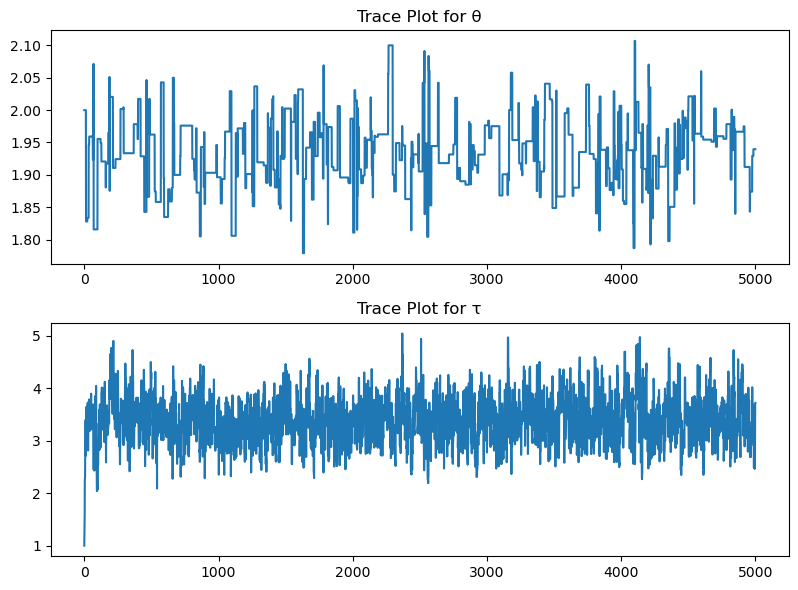

In [126]:
np.random.seed(30)

n_samples = 100
true_theta = 2
true_tau = 4

data_samples = stats.norm(loc=true_theta, scale=1/np.sqrt(true_tau)).rvs(size=n_samples)

n_iter = 5000
alpha = 3
beta = 1.5

theta_samples, tau_samples = metropolis_within_gibbs_truncnorm(
    n_iter, data_samples, alpha, beta, s_theta=1.0, s_tau=0.6  # Tuned proposal scales
)

# Posterior summaries
print_posterior_summaries(theta_samples, tau_samples, "Single Chain")

fig, ax = plt.subplots(2, 1, figsize=(8, 6))

ax[0].plot(theta_samples)
ax[0].set_title("Trace Plot for θ")

ax[1].plot(tau_samples)
ax[1].set_title("Trace Plot for τ")

plt.tight_layout()
plt.show()


In Gibbs sampling, having closed-form full conditional distributions simplifies the sampling because we can directly sample from known distributions. However, this is not always possible, especially in complex models.
When full conditionals are intractable, Metropolis-within-Gibbs provides flexibility and allows us to work around to deal with acceptance probability, which is known to us as long as we obtain the kernel distribution.

&nbsp;

## Q3 

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

> For example 
>
> $\begin{align}
\Pr(s_1 \rightarrow s_1) &={}
q(\tilde x^{(t)}=1 | x^{(t-1)}=1) + q(\tilde x^{(t)}=0 | x^{(t-1)}=1) \left(1- \frac{p(\tilde x^{(t)}=0)}{p(x^{(t-1)}=1)}\right)\\
&={} 1/2 + (1/2)(1-(1/3)/(2/3)) = 0.75
\end{align}$



This **transition kernel** $K$ means that

- if we're currently a $0$ there's a 50\% chance that we'll stay a $0$ and 50\% chance that we'll change to a $1$
- and if we're currently a $1$ there's a 75\% chance that we'll stay a $1$ and 25\% chance that we'll change to a $0$

which specifies [geometric distributions](https://en.wikipedia.org/wiki/Geometric_distribution) with, respectively, expected values of $1$ and $3$ "failures before transitioning to the other state" which means that on average a "$0$ state" will be a run of two $0$'s while a "$1$ state" will be a run of four $1$'s which leads to the desired one-to-two (or one-thirds to two-thirds) ratio of $0$'s and $1$ is the Markov Chain. 


In [ ]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by A sequentially
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
K = np.array([[.5,.25],[.5,.75]]) 
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1's here are "+str(s_t.mean()));

In [ ]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by K 
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1,T):
    if s_t[t]==s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length += [run_length]
        else:
            state1_run_length += [run_length]        
        run_length = 1
        
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths on aveage here are "+str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths on aveage here are "+str(np.mean(state1_run_length).round(3)));


&nbsp;

### Solution

Given:
- **Proposal distribution:**
$$
q(\tilde{x}^{(t)} | x^{(t-1)}) = \left(\frac{1}{2}\right)^{1 - \tilde{x}^{(t)}} \left(\frac{1}{2}\right)^{\tilde{x}^{(t)}}
$$
- **Target stationary distribution:**
$$
p(x^{(t)}) = \left(\frac{1}{3}\right)^{1 - x^{(t)}} \left(\frac{2}{3}\right)^{x^{(t)}}
$$


**When $\tilde{x}^{(t)} = 0$:**
$$
q(0 | x^{(t-1)}) = \left(\frac{1}{2}\right)^{1 - 0} \left(\frac{1}{2}\right)^0 = \frac{1}{2}
$$

**When $\tilde{x}^{(t)} = 1$:**
$$
q(1 | x^{(t-1)}) = \left(\frac{1}{2}\right)^{1 - 1} \left(\frac{1}{2}\right)^1 = \frac{1}{2}
$$

Note that both proposal probabilities are equal to 0.5, making the proposal distribution symmetric:
$$
q(0|1) = q(1|0) = q(0|0) = q(1|1) = 0.5
$$

So the acceptance probability becomes:
$$
\alpha(x, \tilde{x}) = \min\left(1, \frac{p(\tilde{x})}{p(x)}\right).
$$


1. **$P(x^{(t)} = 0 \to x^{(t+1)} = 0)$:**  
Staying in state 0 means either proposing 0 and accepting it, or proposing 1 and rejecting it:
$$
P(0 \to 0) = q(0|0) + q(1|0) (1 - \alpha(0,1))
$$
Since $q(0|0) = 0.5$ and $q(1|0) = 0.5$, we have:
$$
\alpha(0,1) = \min\left(1, \frac{(2/3)}{(1/3)}\right) = 1
$$
Thus:
$$
P(0 \to 0) = 0.5 + 0.5 \times (1 - 1) = 0.5
$$

2. **$P(x^{(t)} = 0 \to x^{(t+1)} = 1)$:**  
$$
P(0 \to 1) = q(1|0) \cdot \alpha(0,1) = 0.5 \times 1 = 0.5
$$

3. **$P(x^{(t)} = 1 \to x^{(t+1)} = 0)$:**  
$$
P(1 \to 0) = q(0|1) \cdot \alpha(1,0)
$$
Where:
$$
\alpha(1,0) = \min\left(1, \frac{(1/3)}{(2/3)}\right) = 0.5
$$
So:
$$
P(1 \to 0) = 0.5 \times 0.5 = 0.25
$$

4. **$P(x^{(t)} = 1 \to x^{(t+1)} = 1)$:**  
$$
P(1 \to 1) = q(1|1) + q(0|1)(1 - \alpha(1,0)) = 0.5 + 0.5 \times (1 - 0.5) = 0.5 + 0.25 = 0.75
$$


**Final Transition Kernel $K$:**
$$
K = \begin{bmatrix}
0.5 & 0.25 \\
0.5 & 0.75
\end{bmatrix}
$$
